In [2]:
!pip install pytorch_msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvj

In [3]:
import os
import glob
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from google.colab import drive
from torch.amp import GradScaler, autocast
from pytorch_msssim import SSIM
import matplotlib.pyplot as plt
import random
import shutil
from torch.utils.checkpoint import checkpoint_sequential

In [4]:
# Reinstall PyTorch to ensure CuDNN compatibility
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121
!pip install pytorch-msssim scikit-image matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 123.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

In [8]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
local_base_path = '/content/optimaldataset'
gdrive_base_path = '/content/drive/MyDrive/optimaldataset'
# Define dataset paths
splits = {
    'train': os.path.join(local_base_path, 'Train'),
    'validate': os.path.join(local_base_path, 'Validate'),
    'test': os.path.join(local_base_path, 'Test')
}
sigma = 15
image_size = (256, 256)
output_dir = '/content/drive/MyDrive/denoising_samples'
os.makedirs(output_dir, exist_ok=True)

In [12]:
gdrive_base_path = '/content/drive/MyDrive/optimaldataset'  # Adjust if shortcut has a different name

In [14]:
!ls /content/drive/MyDrive

 195002051_RajveerJadav.pdf
 AdmitCard_190310204080.pdf
 B104V41AdmitCard.pdf
'Colab Notebooks'
'ConfirmationPage_190310204080 (1).pdf'
'ConfirmationPage_190310204080 (2).pdf'
 ConfirmationPage_190310204080.pdf
 denoising_samples
 DSC_0030.NEF
 DSC_0031.NEF
 DSC_0032.NEF
 DSC_0033.JPG
 DSC_0033.NEF
 DSC_0034.JPG
 DSC_0034.NEF
 DSC_0035.JPG
 DSC_0035.NEF
 DSC_0036.JPG
 DSC_0036.NEF
 DSC_0037.JPG
 DSC_0037.NEF
 DSC_0038.JPG
 DSC_0038.NEF
 DSC_0039.JPG
 DSC_0039.NEF
 DSC_0040.JPG
 DSC_0040.NEF
 DSC_0041.JPG
 DSC_0041.NEF
 DSC_0042.JPG
 DSC_0042.NEF
 DSC_0043.JPG
 DSC_0043.NEF
 DSC_0044.JPG
 DSC_0044.NEF
 DSC_0045.JPG
 DSC_0045.NEF
 DSC_0046.JPG
 DSC_0046.NEF
 DSC_0047.JPG
 DSC_0047.NEF
 DSC_0048.JPG
 DSC_0048.NEF
 DSC_0049.JPG
 DSC_0049.NEF
 DSC_0050.JPG
 DSC_0050.NEF
 DSC_0051.JPG
 DSC_0051.NEF
 DSC_0052.JPG
 DSC_0052.NEF
 DSC_0053.JPG
 DSC_0053.NEF
 DSC_0054.JPG
 DSC_0054.NEF
 DSC_0055.JPG
 DSC_0055.NEF
 DSC_0056.JPG
 DSC_0056.NEF
 DSC_0057.JPG
 DSC_0057.NEF
 DSC_0059.JPG
 DSC_0059.NEF


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import shutil, os, time

local_base_path = '/content/optimaldataset'
if not os.path.exists(local_base_path):
    print("📂 Copying dataset to local disk...")
    start_time = time.time()
    shutil.copytree(gdrive_base_path, local_base_path)
    print(f"✅ Dataset copied to {local_base_path} in {time.time() - start_time:.2f} seconds")

📂 Copying dataset to local disk...
✅ Dataset copied to /content/optimaldataset in 189.87 seconds


In [17]:
# Verify folder existence and image sizes
for split, path in splits.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Folder not found: {path}")
    noisy_path = os.path.join(path, f'noisy_sigma{sigma}')
    if not os.path.exists(noisy_path):
        raise FileNotFoundError(f"Noisy folder not found: {noisy_path}")
    print(f"📂 Found {split} folder: {path}")
    sample_files = glob.glob(os.path.join(noisy_path, '*.png'))
    if sample_files:
        sample_img = Image.open(sample_files[0]).convert('RGB')
        if sample_img.size != image_size:
            raise ValueError(f"Expected 256x256 images, found {sample_img.size} in {noisy_path}")

📂 Found train folder: /content/optimaldataset/Train
📂 Found validate folder: /content/optimaldataset/Validate
📂 Found test folder: /content/optimaldataset/Test


In [18]:
# Dataset class
class PairedNoisyCleanDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        self.transform = transform
        split_dir = os.path.join(base_dir, split.capitalize())
        noisy_dir = os.path.join(split_dir, f'noisy_sigma{sigma}')
        self.clean_images = []
        for root, _, files in os.walk(split_dir):
            if os.path.abspath(root) == os.path.abspath(noisy_dir):
                continue
            for f in files:
                if f.lower().endswith('.png'):
                    self.clean_images.append(os.path.join(root, f))
        self.noisy_images = [
            os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)
            if f.lower().endswith('.png')
        ]
        clean_dict = {os.path.basename(p): p for p in self.clean_images}
        noisy_dict = {os.path.basename(p): p for p in self.noisy_images}
        self.matched_clean = []
        self.matched_noisy = []
        for fname in noisy_dict:
            if fname in clean_dict:
                self.matched_clean.append(clean_dict[fname])
                self.matched_noisy.append(noisy_dict[fname])
        print(f"📊 [{split}] Found {len(self.matched_clean)} paired samples")

    def __len__(self):
        return len(self.matched_clean)

    def __getitem__(self, idx):
        noisy_img = Image.open(self.matched_noisy[idx]).convert('RGB')
        clean_img = Image.open(self.matched_clean[idx]).convert('RGB')
        if self.transform:
            seed = torch.randint(0, 2**31, (1,)).item()
            torch.manual_seed(seed)
            noisy_img = self.transform(noisy_img)
            torch.manual_seed(seed)
            clean_img = self.transform(clean_img)
        return noisy_img, clean_img, self.matched_noisy[idx]


In [19]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor()
])
val_test_transform = transforms.ToTensor()

In [21]:
# Datasets and DataLoaders
batch_size = 1
accum_steps = 8  # Effective batch size 8
train_dataset = PairedNoisyCleanDataset(local_base_path, 'train', train_transform)
val_dataset = PairedNoisyCleanDataset(local_base_path, 'validate', val_test_transform)
test_dataset = PairedNoisyCleanDataset(local_base_path, 'test', val_test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f" Test dataset size: {len(test_dataset)}")

📊 [train] Found 3000 paired samples
📊 [validate] Found 1002 paired samples
📊 [test] Found 1002 paired samples
Train dataset size: 3000
Validation dataset size: 1002
 Test dataset size: 1002


In [22]:
# Bi-MSAAE Model (Fixed)
class MultiScaleEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(3, 126, kernel_size=3, padding=1, groups=3),
            nn.Conv2d(126, 126, kernel_size=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True)
        )
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(3, 126, kernel_size=5, padding=2, groups=3),
            nn.Conv2d(126, 126, kernel_size=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True)
        )
        self.residual = nn.Conv2d(3, 252, kernel_size=1)
        self.checkpoint_segments = 2  # For gradient checkpointing

    def forward(self, x):
        if self.training:
            f1 = checkpoint_sequential(self.branch3x3, self.checkpoint_segments, x)
            f2 = checkpoint_sequential(self.branch5x5, self.checkpoint_segments, x)
        else:
            f1 = self.branch3x3(x)
            f2 = self.branch5x5(x)
        res = self.residual(x)
        return torch.cat([f1, f2], dim=1) + res

class NoiseGateModule(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mask = self.conv(x)
        mask = self.sigmoid(mask)
        return x * mask

class ChannelAttentionBlock(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)
        max_out = self.max_pool(x)
        pooled = torch.cat([avg_out, max_out], dim=1)
        attn = self.conv(pooled)
        attn = self.sigmoid(attn)
        return x * attn

class DualHeadDecoder(nn.Module):
    def __init__(self, in_channels=252):
        super().__init__()
        self.structural_head = nn.Sequential(
            nn.Conv2d(in_channels, 126, kernel_size=3, padding=1),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 63, kernel_size=3, padding=1),
            nn.BatchNorm2d(63),
            nn.ReLU(inplace=True),
            nn.Conv2d(63, 33, kernel_size=3, padding=1),
            nn.BatchNorm2d(33),
            nn.ReLU(inplace=True),
            nn.Conv2d(33, 15, kernel_size=3, padding=1),
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3)
        )
        self.texture_head = nn.Sequential(
            nn.Conv2d(in_channels, 126, kernel_size=5, padding=2),
            nn.BatchNorm2d(126),
            nn.ReLU(inplace=True),
            nn.Conv2d(126, 63, kernel_size=5, padding=2),
            nn.BatchNorm2d(63),
            nn.ReLU(inplace=True),
            nn.Conv2d(63, 33, kernel_size=5, padding=2),
            nn.BatchNorm2d(33),
            nn.ReLU(inplace=True),
            nn.Conv2d(33, 15, kernel_size=5, padding=2),
            nn.BatchNorm2d(15),
            nn.ReLU(inplace=True),
            nn.Conv2d(15, 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(3)
        )
        self.alpha = nn.Parameter(torch.tensor(0.6))
        self.checkpoint_segments = 2

    def forward(self, x):
        if self.training:
            struct = checkpoint_sequential(self.structural_head, self.checkpoint_segments, x)
            text = checkpoint_sequential(self.texture_head, self.checkpoint_segments, x)
        else:
            struct = self.structural_head(x)
            text = self.texture_head(x)
        return self.alpha * struct + (1 - self.alpha) * text

class SharpeningModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, kernel_size=3, padding=1, bias=False)
        laplacian = torch.tensor([[[[0, -1, 0], [-1, 4, -1], [0, -1, 0]]]], dtype=torch.float32)
        laplacian = laplacian.repeat(3, 3, 1, 1)
        self.conv.weight = nn.Parameter(laplacian)
        self.strength = nn.Parameter(torch.tensor(0.7))

    def forward(self, x):
        edges = self.conv(x)
        return x + self.strength * edges

class BiMSAAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MultiScaleEncoder()
        self.noise_gate = NoiseGateModule()
        self.attention = ChannelAttentionBlock()
        self.decoder = DualHeadDecoder()
        self.sharpen = SharpeningModule()
        self.skip_conv = nn.Conv2d(252, 252, kernel_size=1)

    def forward(self, x):
        f = self.encoder(x)
        skip = self.skip_conv(f)
        f = self.noise_gate(f)
        f = self.attention(f)
        f = f + skip
        out = self.decoder(f)
        out = torch.sigmoid(out)
        out = self.sharpen(out)
        return torch.clamp(out, 0, 1)


In [23]:
# Edge Loss
class EdgeLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.sobel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], dtype=torch.float32).repeat(3, 1, 1, 1)
        self.sobel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], dtype=torch.float32).repeat(3, 1, 1, 1)
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        self.sobel_x = self.sobel_x.to(output.device)
        self.sobel_y = self.sobel_y.to(output.device)
        grad_x_out = F.conv2d(output, self.sobel_x, groups=3)
        grad_y_out = F.conv2d(output, self.sobel_y, groups=3)
        grad_x_tgt = F.conv2d(target, self.sobel_x, groups=3)
        grad_y_tgt = F.conv2d(target, self.sobel_y, groups=3)
        return self.mse(grad_x_out, grad_x_tgt) + self.mse(grad_y_out, grad_y_tgt)


In [24]:
# Simplified Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:9].eval()  # Up to conv3_3
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        output_vgg = self.vgg(output)
        target_vgg = self.vgg(target)
        return self.mse(output_vgg, target_vgg)

In [25]:
# Training function
def train_model(model, train_loader, val_loader, mse_criterion, perceptual_criterion, ssim_criterion, edge_criterion, optimizer, scheduler, device, num_epochs, warmup_epochs=5, accum_steps=8):
    model.to(device)
    scaler = GradScaler('cuda')
    best_psnr = 0.0
    best_model_path = '/content/drive/MyDrive/bi_msaae_model_sigma15_256x256_best.pth'
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        lr = optimizer.param_groups[0]['lr']
        if epoch < warmup_epochs:
            lr_factor = (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * lr_factor
        optimizer.zero_grad()
        for i, (noisy, clean, _) in enumerate(train_loader):
            noisy, clean = noisy.to(device), clean.to(device)
            with autocast(device_type='cuda'):
                outputs = model(noisy)
                mse_loss = mse_criterion(outputs, clean)
                perceptual_loss = perceptual_criterion(outputs, clean)
                ssim_loss = 1 - ssim_criterion(outputs, clean)
                edge_loss = edge_criterion(outputs, clean)
                loss = 0.5 * mse_loss + 0.3 * perceptual_loss + 0.1 * ssim_loss + 0.1 * edge_loss
                loss = loss / accum_steps
            scaler.scale(loss).backward()
            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            train_loss += loss.item() * accum_steps * noisy.size(0)
            torch.cuda.empty_cache()
        model.eval()
        val_loss, psnr_val, ssim_val = 0.0, 0.0, 0.0
        with torch.no_grad():
            for noisy, clean, _ in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)
                with autocast(device_type='cuda'):
                    outputs = model(noisy)
                    mse_loss = mse_criterion(outputs, clean)
                    perceptual_loss = perceptual_criterion(outputs, clean)
                    ssim_loss = 1 - ssim_criterion(outputs, clean)
                    edge_loss = edge_criterion(outputs, clean)
                    loss = 0.5 * mse_loss + 0.3 * perceptual_loss + 0.1 * ssim_loss + 0.1 * edge_loss
                val_loss += loss.item() * noisy.size(0)
                outputs_np = outputs.cpu().numpy()
                clean_np = clean.cpu().numpy()
                for i in range(outputs_np.shape[0]):
                    psnr_channels = [
                        peak_signal_noise_ratio(clean_np[i, c], outputs_np[i, c], data_range=1.0)
                        for c in range(3)
                    ]
                    ssim_channels = [
                        structural_similarity(clean_np[i, c], outputs_np[i, c], data_range=1.0, win_size=7)
                        for c in range(3)
                    ]
                    psnr_val += sum(psnr_channels) / 3
                    ssim_val += sum(ssim_channels) / 3
        val_loss /= len(val_dataset)
        psnr_val /= len(val_dataset)
        ssim_val /= len(val_dataset)
        avg_train_loss = train_loss / len(train_dataset)
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        if epoch >= warmup_epochs:
            scheduler.step()
        print(f"\r\033[96mEpoch {epoch+1}/{num_epochs} [{100*(epoch+1)/num_epochs:.1f}%]\033[0m")
        print(f"🌟 Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f} | PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f} | Time: {epoch_time:.2f}s | LR: {current_lr:.6e}")
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f'/content/drive/MyDrive/bi_msaae_model_sigma15_256x256_epoch{epoch+1}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f"💾 Checkpoint saved to {checkpoint_path}")
        if psnr_val > best_psnr:
            best_psnr = psnr_val
            torch.save(model.state_dict(), best_model_path)
            print(f"🏆 New best model saved to {best_model_path} (PSNR: {psnr_val:.2f})")
        if psnr_val > 33 and ssim_val > 0.92 and epoch >= 20:
            print(f"🎯 Target metrics achieved at epoch {epoch+1}. Stopping training.")
            break
        torch.cuda.empty_cache()

In [26]:

# Device and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiMSAAE().to(device)
mse_criterion = nn.MSELoss()
perceptual_criterion = PerceptualLoss().to(device)
ssim_criterion = SSIM(data_range=1.0, channel=3, win_size=7).to(device)
edge_criterion = EdgeLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=95)
num_epochs = 100

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 181MB/s]


In [27]:
model = BiMSAAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()  # Or a combination like MSE + SSIM
scaler = GradScaler()  # For mixed precision

num_epochs = 50
drive_checkpoint_dir = '/content/drive/MyDrive/bimsaae_checkpoints/'

import os
import glob
os.makedirs(drive_checkpoint_dir, exist_ok=True)

# ==== Resume Logic ====
checkpoint_paths = sorted(glob.glob(os.path.join(drive_checkpoint_dir, 'bimsaae_epoch_*.pth')))
start_epoch = 0
if checkpoint_paths:
    latest_checkpoint = checkpoint_paths[-1]
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    model.load_state_dict(torch.load(latest_checkpoint))
    start_epoch = int(latest_checkpoint.split('_')[-1].split('.')[0])
else:
    print("No checkpoint found. Starting from scratch.")

# ==== Training Loop ====
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0

    for i, (noisy, clean, _) in enumerate(train_loader):
        noisy, clean = noisy.to(device), clean.to(device)

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            output = model(noisy)
            loss = criterion(output, clean)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

    checkpoint_path = os.path.join(drive_checkpoint_dir, f'bimsaae_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")

No checkpoint found. Starting from scratch.


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:553: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  "parameter should be passed explicitly. "
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  


Epoch 1/50, Loss: 0.020905
Saved checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_1.pth
Epoch 2/50, Loss: 0.013865
Saved checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_2.pth
Epoch 3/50, Loss: 0.011346
Saved checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_3.pth
Epoch 4/50, Loss: 0.009450
Saved checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_4.pth
Epoch 5/50, Loss: 0.008098
Saved checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_5.pth
Epoch 6/50, Loss: 0.006880
Saved checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_6.pth
Epoch 7/50, Loss: 0.006056
Saved checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_7.pth
Epoch 8/50, Loss: 0.005357
Saved checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_8.pth
Epoch 9/50, Loss: 0.004795
Saved checkpoint: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_epoch_9.pth
Epoch 10/50, Loss: 0.004290


In [28]:
final_model_path = os.path.join(drive_checkpoint_dir, 'bimsaae_final.pth')
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to: {final_model_path}")

Final model saved to: /content/drive/MyDrive/bimsaae_checkpoints/bimsaae_final.pth


In [30]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 15.8 MB/s eta 0:00:00


In [36]:
# Simplified Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:9].eval()  # Up to conv3_3
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.to(dtype=torch.float32)  # Ensure VGG is in float32
        self.mse = nn.MSELoss()

    def forward(self, output, target):
        # Ensure inputs are float32
        output = output.to(dtype=torch.float32)
        target = target.to(dtype=torch.float32)
        output_vgg = self.vgg(output)
        target_vgg = self.vgg(target)
        return self.mse(output_vgg, target_vgg)

In [37]:
# Test evaluation and visualization
model.eval()
test_loss, inference_times = 0.0, []
psnr_noisy_clean, psnr_noisy_denoised, psnr_clean_denoised = [], [], []
ssim_noisy_clean, ssim_noisy_denoised, ssim_clean_denoised = [], [], []
sample_images = []
num_samples = 5


Displaying Sample 1 (03007.png)


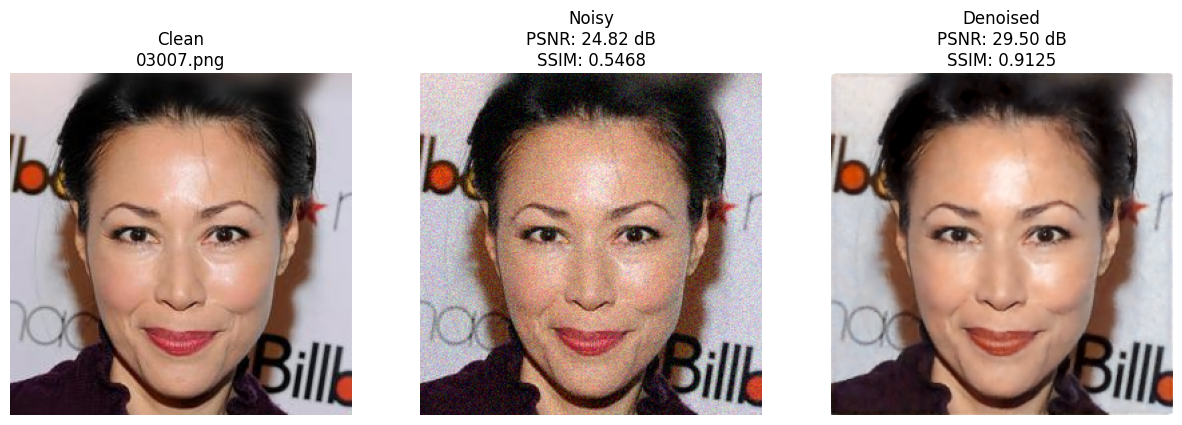


Displaying Sample 2 (03251.png)


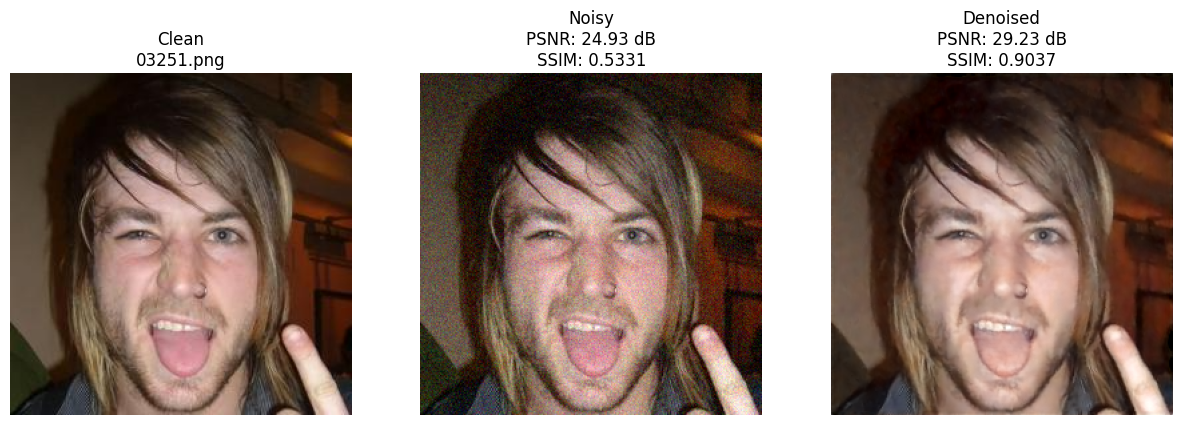


Displaying Sample 3 (03794.png)


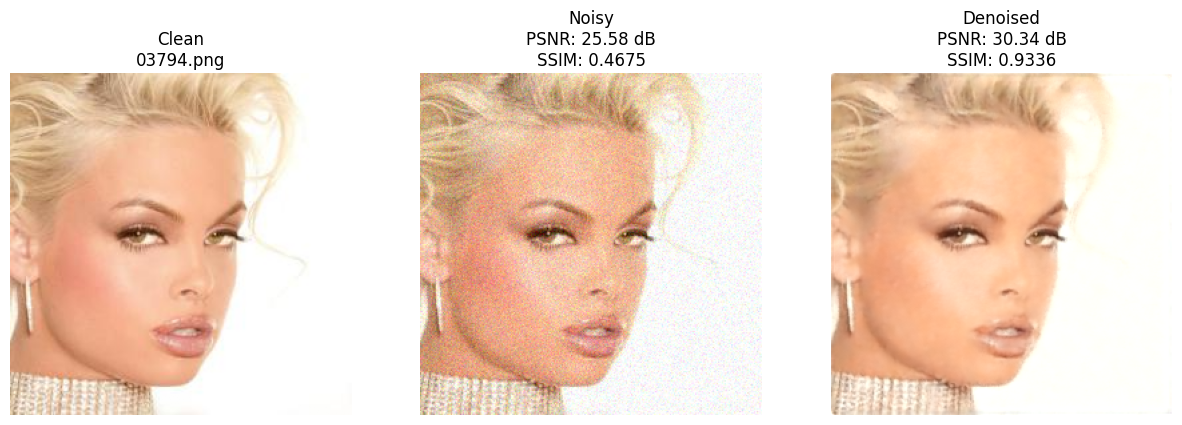


Displaying Sample 4 (03916.png)


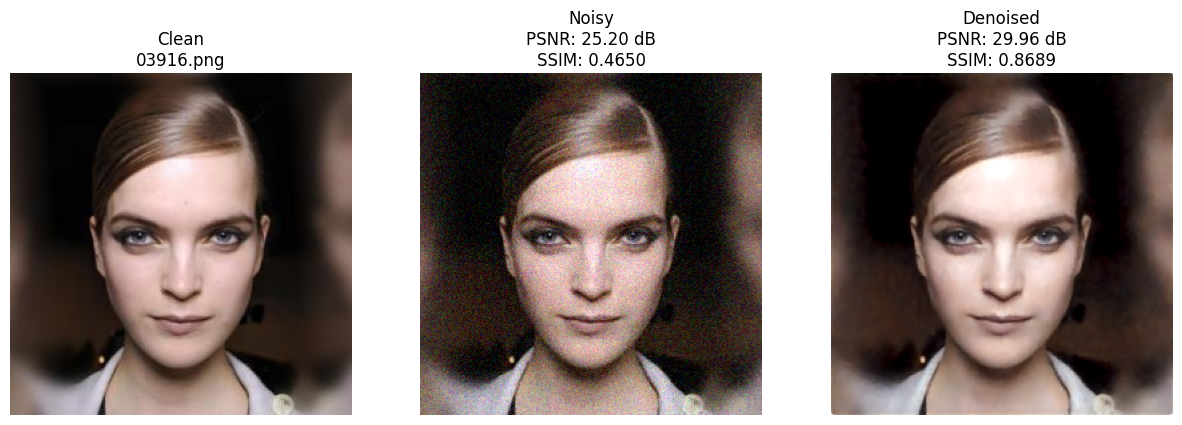


Displaying Sample 5 (03978.png)


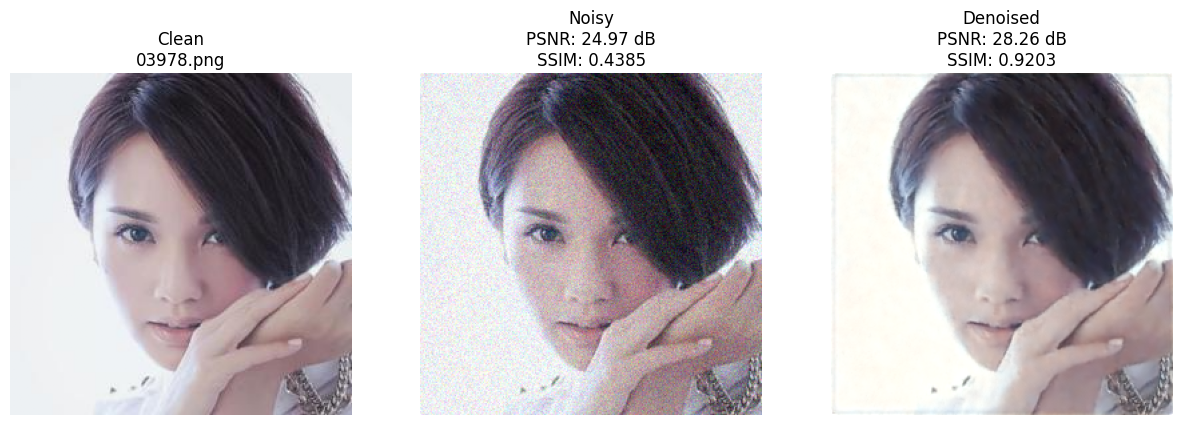

In [44]:
from IPython.display import Image as IPyImage, display
from PIL import Image

#Collect samples and metrics
with torch.no_grad():
    test_samples = random.sample(list(test_dataset), min(num_samples, len(test_dataset)))
    for idx, (noisy, clean, noisy_path) in enumerate(test_samples):
        noisy, clean = noisy.unsqueeze(0).to(device), clean.unsqueeze(0).to(device)
        # Run inference in autocast
        start_time = time.time()
        with autocast(device_type='cuda'):
            denoised = model(noisy)
        inference_times.append((time.time() - start_time) * 1000)
        # Compute losses outside autocast to avoid type mismatches
        denoised = denoised.to(dtype=torch.float32)  # Ensure float32 for loss
        clean = clean.to(dtype=torch.float32)
        mse_loss = mse_criterion(denoised, clean)
        perceptual_loss = perceptual_criterion(denoised, clean)
        ssim_loss = 1 - ssim_criterion(denoised, clean)
        edge_loss = edge_criterion(denoised, clean)
        loss = 0.5 * mse_loss + 0.3 * perceptual_loss + 0.1 * ssim_loss + 0.1 * edge_loss
        test_loss += loss.item()
        # Convert to NumPy and normalize
        noisy_np = noisy.cpu().numpy()[0].transpose(1, 2, 0)
        clean_np = clean.cpu().numpy()[0].transpose(1, 2, 0)
        denoised_np = denoised.cpu().numpy()[0].transpose(1, 2, 0)
        # Ensure float32 and clamp to [0, 1]
        noisy_np = np.clip(noisy_np, 0, 1).astype(np.float32)
        clean_np = np.clip(clean_np, 0, 1).astype(np.float32)
        denoised_np = np.clip(denoised_np, 0, 1).astype(np.float32)
        sample_images.append((clean_np, noisy_np, denoised_np, os.path.basename(noisy_path)))
        # Calculate PSNR and SSIM
        psnr_nc = np.mean([
            peak_signal_noise_ratio(clean_np[:, :, c], noisy_np[:, :, c], data_range=1.0)
            for c in range(3)
        ])
        psnr_nd = np.mean([
            peak_signal_noise_ratio(noisy_np[:, :, c], denoised_np[:, :, c], data_range=1.0)
            for c in range(3)
        ])
        psnr_cd = np.mean([
            peak_signal_noise_ratio(clean_np[:, :, c], denoised_np[:, :, c], data_range=1.0)
            for c in range(3)
        ])
        ssim_nc = np.mean([
            structural_similarity(clean_np[:, :, c], noisy_np[:, :, c], data_range=1.0, win_size=7)
            for c in range(3)
        ])
        ssim_nd = np.mean([
            structural_similarity(noisy_np[:, :, c], denoised_np[:, :, c], data_range=1.0, win_size=7)
            for c in range(3)
        ])
        ssim_cd = np.mean([
            structural_similarity(clean_np[:, :, c], denoised_np[:, :, c], data_range=1.0, win_size=7)
            for c in range(3)
        ])
        psnr_noisy_clean.append(psnr_nc)
        psnr_noisy_denoised.append(psnr_nd)
        psnr_clean_denoised.append(psnr_cd)
        ssim_noisy_clean.append(ssim_nc)
        ssim_noisy_denoised.append(ssim_nd)
        ssim_clean_denoised.append(ssim_cd)
        # Save and display triplet
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(clean_np)
        plt.title(f"Clean\n{os.path.basename(noisy_path)}")
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(noisy_np)
        plt.title(f"Noisy\nPSNR: {psnr_nc:.2f} dB\nSSIM: {ssim_nc:.4f}")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(denoised_np)
        plt.title(f"Denoised\nPSNR: {psnr_cd:.2f} dB\nSSIM: {ssim_cd:.4f}")
        plt.axis('off')
        # Save image
        sample_path = os.path.join(output_dir, f'sample_{idx+1}.png')
        plt.savefig(sample_path, format='png', dpi=100, bbox_inches='tight')
        plt.close()
        # Display image in Colab
        print(f"\nDisplaying Sample {idx+1} ({os.path.basename(noisy_path)})")
        display(IPyImage(filename=sample_path))  # Use IPython.display.Image
        torch.cuda.empty_cache()


Displaying PSNR/SSIM Comparison Plot


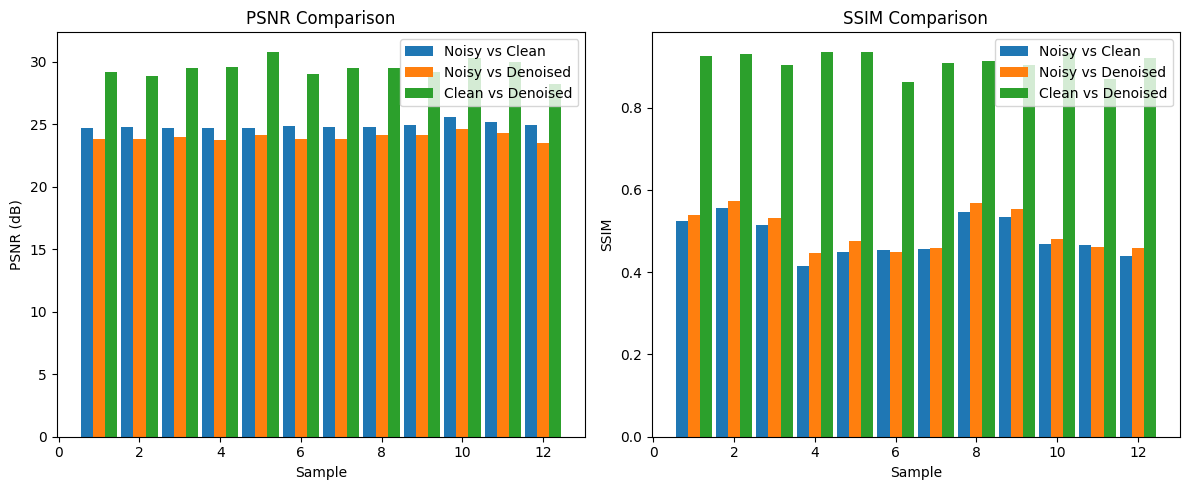

In [49]:
from IPython.display import display, Image

# Plot PSNR and SSIM
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
num_metrics = len(psnr_noisy_clean)  # Auto-adapt to available metrics
x = np.arange(1, num_metrics + 1)

plt.bar(x - 0.3, psnr_noisy_clean, 0.3, label='Noisy vs Clean', color='#1f77b4')
plt.bar(x, psnr_noisy_denoised, 0.3, label='Noisy vs Denoised', color='#ff7f0e')
plt.bar(x + 0.3, psnr_clean_denoised, 0.3, label='Clean vs Denoised', color='#2ca02c')
plt.xlabel('Sample')
plt.ylabel('PSNR (dB)')
plt.title('PSNR Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x - 0.3, ssim_noisy_clean, 0.3, label='Noisy vs Clean', color='#1f77b4')
plt.bar(x, ssim_noisy_denoised, 0.3, label='Noisy vs Denoised', color='#ff7f0e')
plt.bar(x + 0.3, ssim_clean_denoised, 0.3, label='Clean vs Denoised', color='#2ca02c')
plt.xlabel('Sample')
plt.ylabel('SSIM')
plt.title('SSIM Comparison')
plt.legend()

plt.tight_layout()
plot_path = os.path.join(output_dir, 'psnr_ssim_plots.png')
plt.savefig(plot_path, format='png', dpi=100, bbox_inches='tight')
plt.close()

# Display PSNR/SSIM plot
print("\nDisplaying PSNR/SSIM Comparison Plot")
display(Image(filename=plot_path))

In [50]:
# Print metrics
print(f"📊 Test Results: Loss: {test_loss/len(test_samples):.6f} | Inference Time: {sum(inference_times)/len(inference_times):.2f} ms")
print("\nSample Metrics:")
for i, fname in enumerate([f[3] for f in sample_images]):
    print(f"\nSample {i+1} ({fname}):")
    print(f"  Noisy vs Clean: PSNR: {psnr_noisy_clean[i]:.2f} dB, SSIM: {ssim_noisy_clean[i]:.4f}")
    print(f"  Noisy vs Denoised: PSNR: {psnr_noisy_denoised[i]:.2f} dB, SSIM: {ssim_noisy_denoised[i]:.4f}")
    print(f"  Clean vs Denoised: PSNR: {psnr_clean_denoised[i]:.2f} dB, SSIM: {ssim_clean_denoised[i]:.4f}")
print(f"\n📸 Sample images and plots saved to {output_dir}")


📊 Test Results: Loss: 0.103277 | Inference Time: 6.44 ms

Sample Metrics:

Sample 1 (03468.png):
  Noisy vs Clean: PSNR: 24.71 dB, SSIM: 0.5253
  Noisy vs Denoised: PSNR: 23.85 dB, SSIM: 0.5382
  Clean vs Denoised: PSNR: 29.18 dB, SSIM: 0.9253

Sample 2 (03301.png):
  Noisy vs Clean: PSNR: 24.78 dB, SSIM: 0.5556
  Noisy vs Denoised: PSNR: 23.85 dB, SSIM: 0.5743
  Clean vs Denoised: PSNR: 28.84 dB, SSIM: 0.9305

Sample 3 (03368.png):
  Noisy vs Clean: PSNR: 24.68 dB, SSIM: 0.5145
  Noisy vs Denoised: PSNR: 24.00 dB, SSIM: 0.5317
  Clean vs Denoised: PSNR: 29.52 dB, SSIM: 0.9032

Sample 4 (03617.png):
  Noisy vs Clean: PSNR: 24.67 dB, SSIM: 0.4155
  Noisy vs Denoised: PSNR: 23.77 dB, SSIM: 0.4469
  Clean vs Denoised: PSNR: 29.62 dB, SSIM: 0.9350

Sample 5 (03689.png):
  Noisy vs Clean: PSNR: 24.73 dB, SSIM: 0.4481
  Noisy vs Denoised: PSNR: 24.17 dB, SSIM: 0.4760
  Clean vs Denoised: PSNR: 30.83 dB, SSIM: 0.9364

Sample 6 (03411.png):
  Noisy vs Clean: PSNR: 24.86 dB, SSIM: 0.4551
  Nois

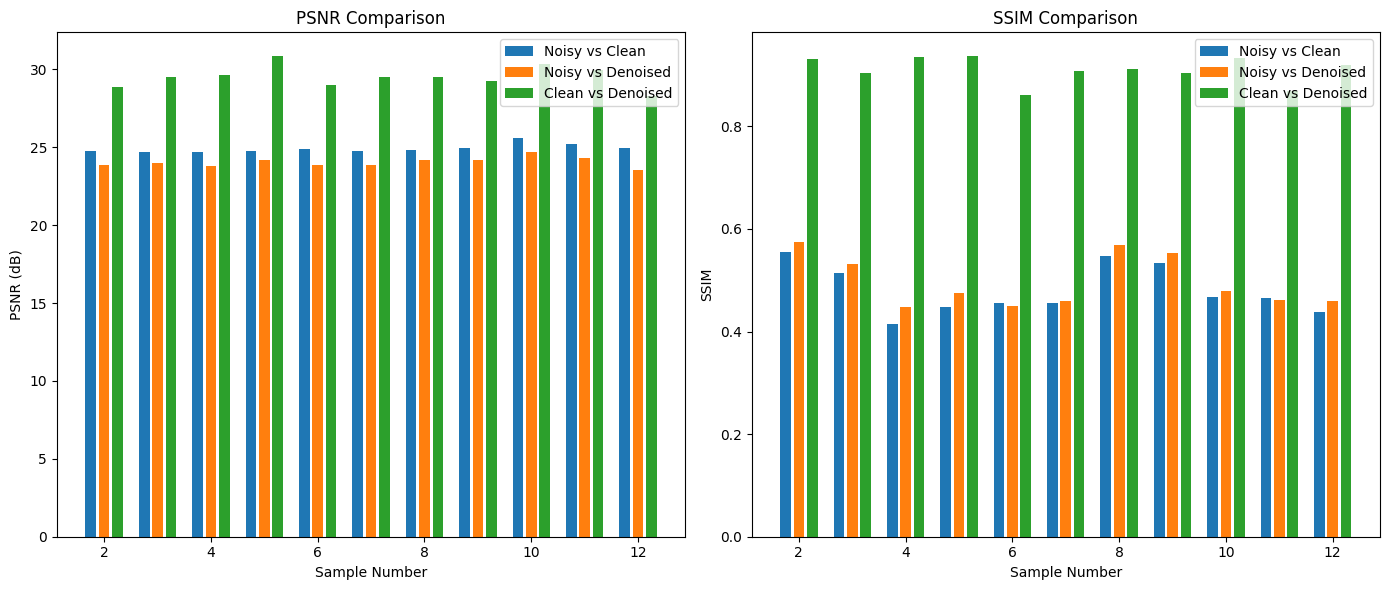

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Sample indices (2 to 12)
samples = np.arange(2, 13)

# PSNR values (Noisy vs Clean)
psnr_noisy_clean = np.array([24.78, 24.68, 24.67, 24.73, 24.86, 24.75, 24.82, 24.93, 25.58, 25.20, 24.97])

# PSNR values (Noisy vs Denoised)
psnr_noisy_denoised = np.array([23.85, 24.00, 23.77, 24.17, 23.86, 23.85, 24.15, 24.17, 24.66, 24.28, 23.51])

# PSNR values (Clean vs Denoised)
psnr_clean_denoised = np.array([28.84, 29.52, 29.62, 30.83, 29.01, 29.49, 29.50, 29.23, 30.34, 29.96, 28.26])

# SSIM values (Noisy vs Clean)
ssim_noisy_clean = np.array([0.5556, 0.5145, 0.4155, 0.4481, 0.4551, 0.4559, 0.5468, 0.5331, 0.4675, 0.4650, 0.4385])

# SSIM values (Noisy vs Denoised)
ssim_noisy_denoised = np.array([0.5743, 0.5317, 0.4469, 0.4760, 0.4494, 0.4596, 0.5682, 0.5539, 0.4798, 0.4612, 0.4595])

# SSIM values (Clean vs Denoised)
ssim_clean_denoised = np.array([0.9305, 0.9032, 0.9350, 0.9364, 0.8616, 0.9085, 0.9125, 0.9037, 0.9336, 0.8689, 0.9203])

# Plotting
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(samples - 0.25, psnr_noisy_clean, width=0.2, label='Noisy vs Clean', color='#1f77b4')
plt.bar(samples, psnr_noisy_denoised, width=0.2, label='Noisy vs Denoised', color='#ff7f0e')
plt.bar(samples + 0.25, psnr_clean_denoised, width=0.2, label='Clean vs Denoised', color='#2ca02c')
plt.xlabel('Sample Number')
plt.ylabel('PSNR (dB)')
plt.title('PSNR Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(samples - 0.25, ssim_noisy_clean, width=0.2, label='Noisy vs Clean', color='#1f77b4')
plt.bar(samples, ssim_noisy_denoised, width=0.2, label='Noisy vs Denoised', color='#ff7f0e')
plt.bar(samples + 0.25, ssim_clean_denoised, width=0.2, label='Clean vs Denoised', color='#2ca02c')
plt.xlabel('Sample Number')
plt.ylabel('SSIM')
plt.title('SSIM Comparison')
plt.legend()

plt.tight_layout()
plt.show()